In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql

<img src = "chinook Tables.png" width="70%"/>

In [2]:
conn = sql.connect("chinook.db")

In [3]:
def read_sql(q):
    return pd.read_sql_query(q, conn)

In [4]:
q = """select invoice_id, track_id
       From invoice_line
       group by 1"""

read_sql(q)

,invoice_id,track_id
0,1,1158
1,2,3476
2,3,2516
3,4,3448
4,5,1986
...,...,...
609,610,1053
610,611,2663
611,612,2204
612,613,1865


In [6]:
q = """with 

       first_track  as (select invoice_id, track_id
       From invoice_line
       group by 1),
       
       album_p as (
       
       select ft.*, case 
       when 
    (
       select t.track_id from track t
       where t.album_id = (select t2.album_id from track t2
       where t2.track_id = ft.track_id)
       
       Except
       
       select il2.track_id from invoice_line il2
       where il2.invoice_id = ft.invoice_id
       ) is Null
       
       and 
       
       (
        select il2.track_id from invoice_line il2
       where il2.invoice_id = ft.invoice_id
       
       Except
       
      select t.track_id from track t
       where t.album_id = (select t2.album_id from track t2
       where t2.track_id = ft.track_id)
       ) 
       is Null
       then "Yes"
       else "NO"
       end as Album_purchased
       from first_track ft
       )
       
       select Album_purchased, count(invoice_id) number_of_invoces from album_p
       group by 1
         
       """

read_sql(q)

,Album_purchased,number_of_invoces
0,NO,500
1,Yes,114


In [7]:
q = """select t2.album_id from track t2
       where t2.track_id = 0 """

read_sql(q)

,album_id


In [8]:
q = """select invoice_id, track_id
       From invoice_line
       group by invoice_id
       having invoice_id in (1,2)
       
       intersect
       
       select invoice_id, track_id
       From invoice_line
       group by invoice_id
       having invoice_id = 3
    
       """

read_sql(q)

,invoice_id,track_id


In [12]:
q="""Select c.country
       from customer c """
read_sql(q)

,country
0,Brazil
1,Germany
2,Canada
3,Norway
4,Czech Republic
5,Czech Republic
6,Austria
7,Belgium
8,Denmark
9,Brazil


In [13]:
q="""Select c.country, count(distinct(i.customer_id)) total_cst,
       sum(i.total) tot_sales, sum(i.total)/count(i.customer_id) avg_order,
       sum(total)/count(distinct(i.customer_id)) life_time_value
       from customer c 
       left join invoice i
       on c.customer_id=i.customer_id
       group by 1
       order by 2 desc"""
read_sql(q)

,country,total_cst,tot_sales,avg_order,life_time_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,France,5,389.07,7.781400,77.814000
3,Brazil,5,427.68,7.011148,85.536000
4,Germany,4,334.62,8.161463,83.655000
5,United Kingdom,3,245.52,8.768571,81.840000
6,Portugal,2,185.13,6.383793,92.565000
7,India,2,183.15,8.721429,91.575000
8,Czech Republic,2,273.24,9.108000,136.620000
9,Sweden,1,75.24,7.524000,75.240000


In [14]:
q = """with

       c_d as (Select c.country, count(distinct(i.customer_id)) total_cst,
       sum(i.total) tot_sales, sum(i.total)/count(i.customer_id) avg_order,
       sum(total)/count(distinct(i.customer_id)) life_time_value
       from customer c
      left join invoice i
      on i.customer_id = c.customer_id
      group by 1),
      
     updated as ( select case
      when total_cst =1 then "others"
      else country
      end as country, total_cst,
      tot_sales,avg_order,life_time_value
      from c_d),
      
      final as (select country, sum(total_cst) total_cst,
      sum(tot_sales) tot_sales, 
      sum(avg_order)/count(avg_order) as avg_order,
      sum(life_time_value)/count(life_time_value) life_time_value
      from updated
      group by 1),
      
      latest  as (select *, case 
      when country = "others"
      then 0
      else 1
      end as ord
      from final
      order by 6 desc, tot_sales Desc)
      
      select country,total_cst,tot_sales,avg_order,life_time_value
      from latest
      """

read_sql(q)

,country,total_cst,tot_sales,avg_order,life_time_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,others,15,1094.94,7.445071,72.996000


In [15]:
df = read_sql(q)

In [16]:
df.head()

,country,total_cst,tot_sales,avg_order,life_time_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000


In [17]:
country = df.set_index("country")
country.index.name = None

In [18]:
country.head()

,total_cst,tot_sales,avg_order,life_time_value
USA,13,1040.49,7.942672,80.037692
Canada,8,535.59,7.047237,66.948750
Brazil,5,427.68,7.011148,85.536000
France,5,389.07,7.781400,77.814000
Germany,4,334.62,8.161463,83.655000


In [19]:
import matplotlib.pyplot as plt

In [21]:
colors = [plt.cm.Accent(i) for i in np.linspace(0,1, country.shape[0])] # different line p colour krne k liye function bnanya hay

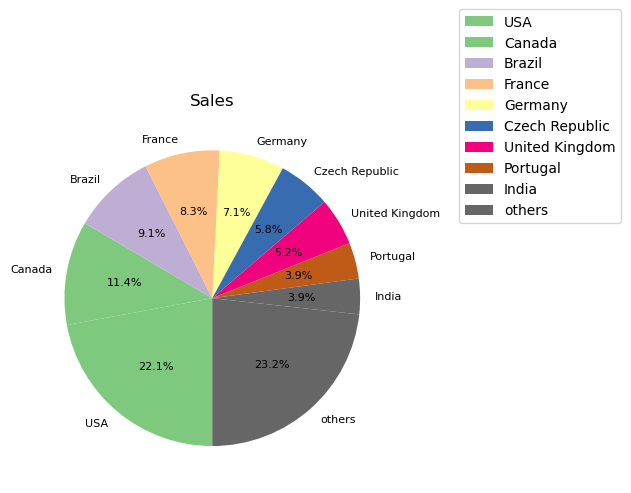

In [22]:
sales = country["tot_sales"]
sales.plot.pie(colormap = plt.cm.Accent, title = "Sales", 
               fontsize = 8,
              startangle = -90, counterclock = False,autopct = "%.1f%%") # autopct show their percentage
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.15,1.3))
plt.show()


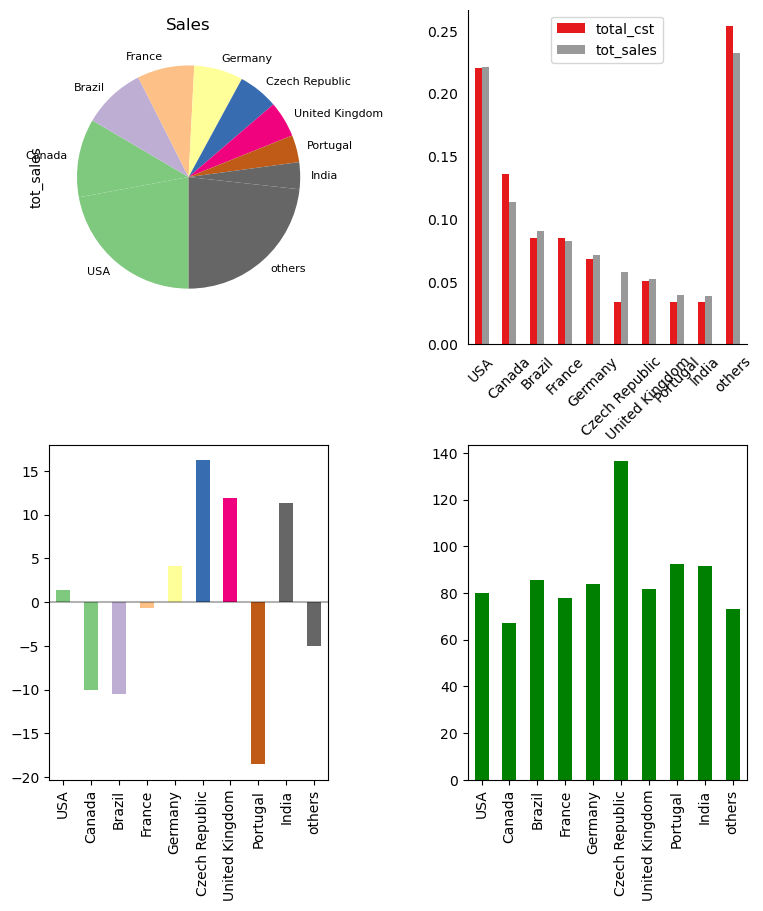

In [23]:
fig, ax = plt.subplots(nrows = 2,ncols = 2, figsize = (9,10))
ax1,ax2, ax3, ax4 = ax.flatten()  # jage ni btane prte khude 1st se start krdeta hay flatten method
plt.subplots_adjust(hspace = 0.3, wspace = 0.5) # plots k bech me spaces

# top left
sales = country["tot_sales"]
sales.plot.pie(ax = ax1, colormap = plt.cm.Accent, title = "Sales", 
               fontsize = 8,
              startangle = -90, counterclock = False)
plt.ylabel("") # not working


# top right

cols = ["total_cst","tot_sales"]

c_s = country[cols].copy()

for c in cols:
    c_s[c] = c_s[c]/sum(c_s[c])
c_s.plot.bar(ax = ax2, rot = 45, colormap = plt.cm.Set1)
ax2.legend(loc= "upper center")
ax2.tick_params(left = False, bottom = False) # remove ticks on line
for i in ["top", "right"]:
    ax2.spines[i].set_visible(False) # remove lines from top, right

# bottom left
avg_ord = country["avg_order"].copy()
avg_ord = (avg_ord*100/avg_ord.mean())-100
avg_ord.plot.bar(ax = ax3, color = colors) # upr colors ka function bnaya hay 18 line p wohe use kr rhe hay
ax3.axhline(0, alpha = 0.3, color = "k") # centre me line bnane k liye

# bottom right
life_time_value=country["life_time_value"]
life_time_value.plot.bar(ax=ax4,color ="green")

plt.show()
